In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 4.4 MB/s 
     |████████████████████████████████| 186 kB 37.8 MB/s 
     |████████████████████████████████| 46 kB 2.9 MB/s 
     |████████████████████████████████| 1.2 MB 36.7 MB/s 
     |████████████████████████████████| 56 kB 2.2 MB/s 
     |████████████████████████████████| 51 kB 194 kB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

In [4]:
Path.BASE_PATH = path
path

Path('.')

In [5]:
pet_test = (path/'images'/'saint_bernard_20.jpg').name
pet_name = " ".join(re.findall("(.+)_\d+\.jpg", pet_test))
pet_name

'saint_bernard'

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


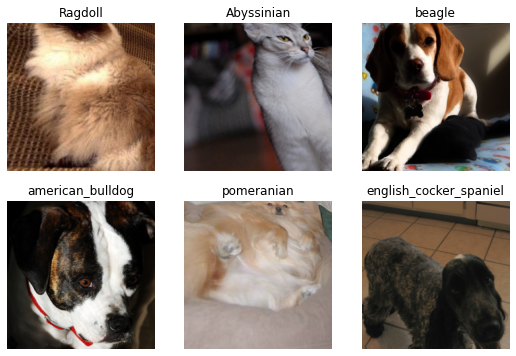

In [6]:
def get_dls(bs, size, path=path):
  pets_block = DataBlock(blocks=(ImageBlock, CategoryBlock),
                         get_items = get_image_files, 
                         get_y = using_attr(RegexLabeller("(.+)_\d+\..+"), "name"),
                         item_tfms = Resize(460),
                         batch_tfms = aug_transforms(size=224, min_scale=0.75, mult=1.5)
  )
  return pets_block.dataloaders(path/"images")

dls = get_dls(128, 64)
dls.show_batch(ncols=3, nrows=2)

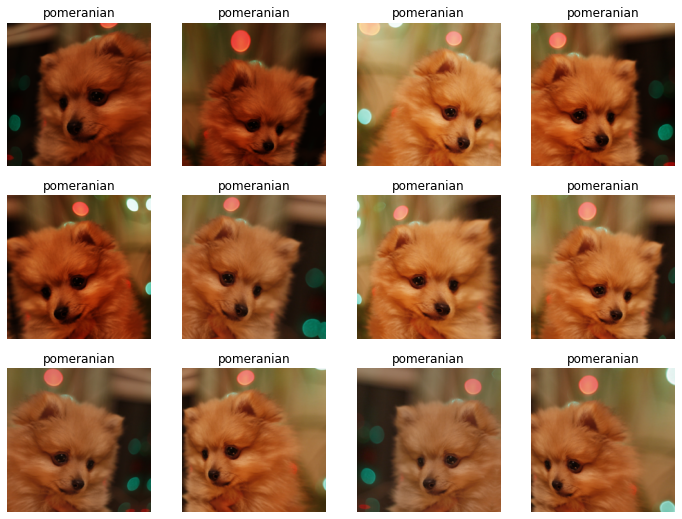

In [7]:
dls.show_batch(max_n = 12, unique=True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


SuggestedLRs(valley=0.00015848931798245758)

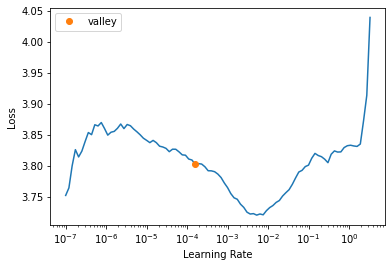

In [8]:
learn = Learner(dls, xresnet34(n_out=dls.c), loss_func=nn.CrossEntropyLoss(), metrics=accuracy)
learn.lr_find()

In [9]:
# train for 5 epochs to test
learn.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.492282,3.517782,0.064276,02:46
1,3.277022,3.100162,0.157645,02:45
2,3.080078,3.004197,0.176590,02:45


In [10]:
learn.dls = get_dls(128, 128)
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.049731,4.120483,0.073072,02:45


epoch,train_loss,valid_loss,accuracy,time
0,2.849808,2.760387,0.241543,02:45
1,2.719809,2.596443,0.279432,02:45
2,2.496962,2.412868,0.338972,02:45


In [11]:
learn.dls = get_dls(64, 224)
learn.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.580111,2.868493,0.230041,02:45


epoch,train_loss,valid_loss,accuracy,time
0,2.411828,2.359844,0.317997,02:45
1,2.276461,2.264763,0.350474,02:45
2,2.054882,1.929130,0.439107,02:45


In [13]:
# check tta accuracy
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.4479)

In [16]:
# see if training with label smoothing helps generalize with more epochs
learn.loss_func = LabelSmoothingCrossEntropy()
learn.loss_func

LabelSmoothingCrossEntropy()

SuggestedLRs(valley=6.30957365501672e-05)

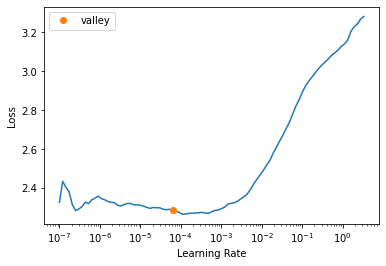

In [17]:
learn.lr_find()

In [18]:
learn.fit_one_cycle(5, 6e-5)

epoch,train_loss,valid_loss,accuracy,time
0,2.285241,2.268295,0.435724,02:46
1,2.272551,2.223444,0.472260,02:45
2,2.237566,2.197846,0.466847,02:45
3,2.195529,2.176754,0.477673,02:45
4,2.166826,2.180384,0.477673,02:45


In [20]:
# retrain model just using mixup
learn = Learner(dls, xresnet34(n_out=dls.c), loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(8, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.578772,3.445860,0.073748,02:46
1,3.461457,3.475992,0.093369,02:45
2,3.319796,3.065298,0.175913,02:45
3,3.182794,3.000278,0.178620,02:45
4,3.023728,2.741990,0.242896,02:45
5,2.876682,2.492314,0.305819,02:45
6,2.755448,2.310936,0.355210,02:45
7,2.669186,2.286731,0.357240,02:45


In [21]:
# check tta accuracy
preds, targs = learn.tta()
accuracy(preds, targs)

TensorBase(0.3559)